In [46]:
!pip install yfinance pandas numpy scikit-learn xgboost tensorflow matplotlib

In [48]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt




In [49]:
# Step 1: Data Collection
def fetch_data(ticker, start_date, end_date):
    ticker_data = yf.Ticker(ticker)
    df = ticker_data.history(period='1d', start=start_date, end=end_date)
    return df

In [51]:
 # Step 2: Feature Engineering
def create_features(data):
    data['SMA_10'] = data['Close'].rolling(window=10).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['EMA_10'] = data['Close'].ewm(span=10, adjust=False).mean()
    data['EMA_50'] = data['Close'].ewm(span=50, adjust=False).mean()

    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    data['RSI'] = 100 - (100 / (1 + rs))

    data['BB_upper'] = data['Close'].rolling(window=20).mean() + 2 * data['Close'].rolling(window=20).std()
    data['BB_lower'] = data['Close'].rolling(window=20).mean() - 2 * data['Close'].rolling(window=20).std()

    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26

    data['Close_1'] = data['Close'].shift(1)
    data['Close_2'] = data['Close'].shift(2)

    data['Rolling_mean_7'] = data['Close'].rolling(window=7).mean()
    data['Rolling_std_7'] = data['Close'].rolling(window=7).std()

    data['Day_of_week'] = data.index.dayofweek
    data['Day_of_month'] = data.index.day
    data['Month'] = data.index.month

    data.dropna(inplace=True)
    return data


In [33]:
# Step 3: Prepare Data for LSTM
def create_lstm_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [52]:
# Step 4: Build and Train Models
def build_models(X_train, y_train):
    models = {
        'linear': LinearRegression(),
        'rf': RandomForestRegressor(n_estimators=200, random_state=42),
        'xgb': XGBRegressor(n_estimators=200, random_state=42)
    }
    for name, model in models.items():
        model.fit(X_train, y_train)
    return models

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


In [53]:
# Step 5: Make Predictions
def make_predictions(models, lstm_model, X_test, X_test_lstm):
    predictions = {}
    for name, model in models.items():
        predictions[name] = model.predict(X_test)
    predictions['lstm'] = lstm_model.predict(X_test_lstm).flatten()
    return predictions

In [54]:
# Step 6: Combine Predictions and Evaluate
def combine_predictions(predictions, weights):
    min_length = min(len(pred) for pred in predictions.values())
    combined_pred = sum(predictions[name][:min_length] * weight for name, weight in weights.items())
    return combined_pred


/Users/Nivya/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 4301.8525 - val_loss: 4037.0979
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3530.6794 - val_loss: 3759.3367
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3164.4067 - val_loss: 3548.8423
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3072.7546 - val_loss: 3370.9026
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2829.9844 - val_loss: 3220.9192
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3080.8123 - val_loss: 3091.7048
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2388.5867 - val_loss: 2987.7141
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2672.5137 - val_loss: 2885.1841
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 2591.6545 - val_loss: 2805.5710
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2370.8772 - val_loss: 2740.3679
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 2459.6646 - val_loss: 2686.00

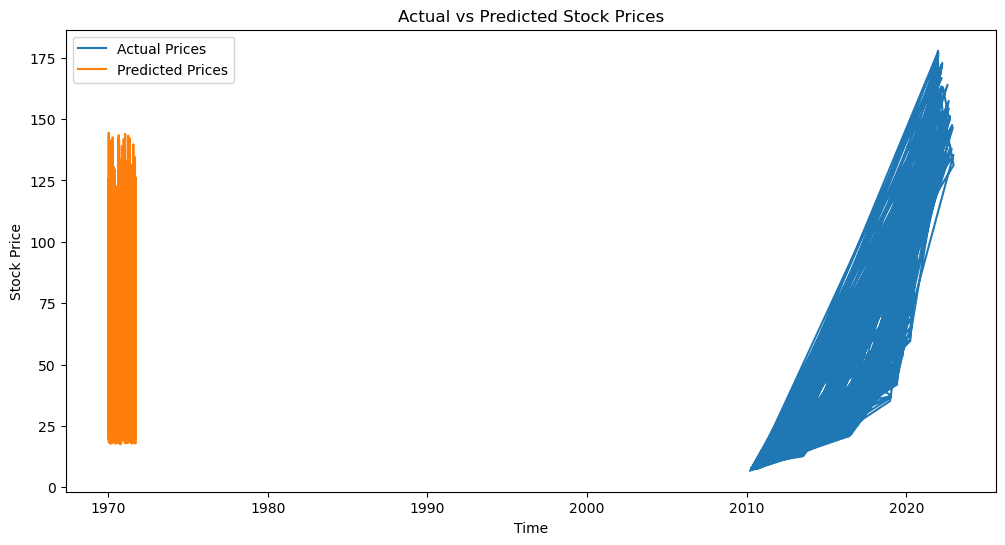

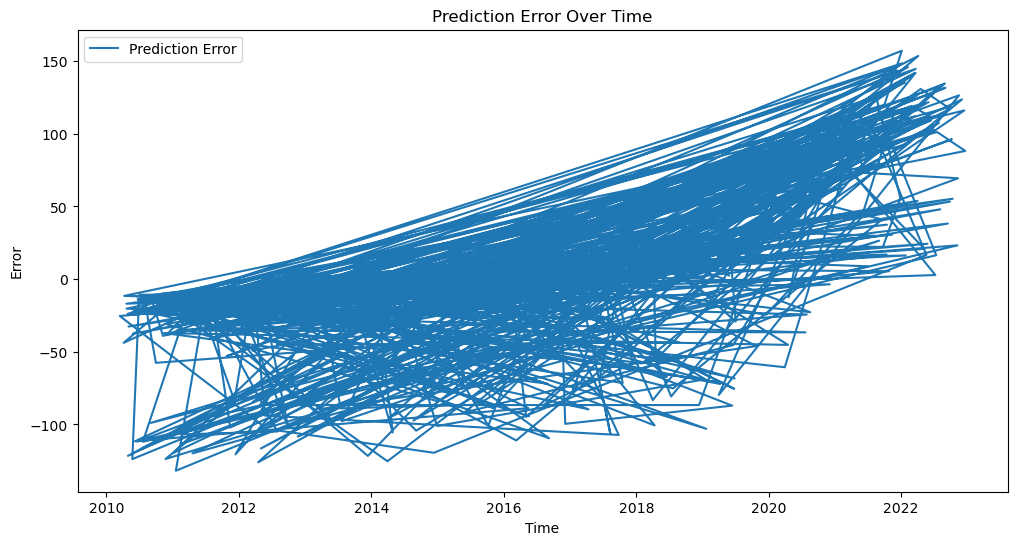

In [55]:
# Main Execution
if __name__ == "__main__":
    # Fetch data
    df = fetch_data('AAPL', '2010-01-01', '2023-01-01')

    # Feature engineering
    df = create_features(df)

    # Prepare data for training
    features = ['SMA_10', 'SMA_50', 'EMA_10', 'EMA_50', 'RSI', 'BB_upper', 'BB_lower', 'MACD', 'Close_1', 'Close_2', 'Rolling_mean_7', 'Rolling_std_7', 'Day_of_week', 'Day_of_month', 'Month']
    X = df[features]
    y = df['Close']

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X = pd.DataFrame(X_scaled, columns=features, index=X.index)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    time_steps = 10
    X_train_lstm, y_train_lstm = create_lstm_dataset(X_train, y_train, time_steps)
    X_test_lstm, y_test_lstm = create_lstm_dataset(X_test, y_test, time_steps)

    # Train models
    models = build_models(X_train, y_train)
    lstm_model = build_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]))
    lstm_model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

    # Make predictions
    predictions = make_predictions(models, lstm_model, X_test, X_test_lstm)

    # Combine predictions
    weights = {'linear': 0.25, 'rf': 0.25, 'xgb': 0.25, 'lstm': 0.25}
    combined_pred = combine_predictions(predictions, weights)

    # Evaluate the ensemble model
    y_test = y_test.iloc[time_steps:]
    mse_ensemble = mean_squared_error(y_test[:len(combined_pred)], combined_pred)
    print(f'Ensemble Model MSE: {mse_ensemble}')

    # Cross-validation
    linear_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=200, random_state=42)
    xgb_model = XGBRegressor(n_estimators=200, random_state=42)

    linear_cv = cross_val_score(linear_model, X, y, cv=5, scoring='neg_mean_squared_error')
    rf_cv = cross_val_score(rf_model, X, y, cv=5, scoring='neg_mean_squared_error')
    xgb_cv = cross_val_score(xgb_model, X, y, cv=5, scoring='neg_mean_squared_error')

    print(f'Linear Regression CV MSE: {-linear_cv.mean()}')
    print(f'Random Forest CV MSE: {-rf_cv.mean()}')
    print(f'XGBoost CV MSE: {-xgb_cv.mean()}')

    # Error analysis plot
    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:len(combined_pred)], label='Actual Prices')
    plt.plot(combined_pred, label='Predicted Prices')
    plt.title('Actual vs Predicted Stock Prices')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(y_test[:len(combined_pred)] - combined_pred, label='Prediction Error')
    plt.title('Prediction Error Over Time')
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.legend()
    plt.show()